# Do not overfit -- Kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score

In [2]:
data_path = 'data/'
train_data = pd.read_csv(f'{data_path}train.csv', index_col = 'id')
test_data = pd.read_csv(f'{data_path}test.csv', index_col = 'id')

In [3]:
corrs = train_data.drop(labels = ['target'], axis = 1).corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(10)

,level_0,level_1,0
89690,79,187,0.243916
89691,187,79,0.243916
89692,140,187,0.244012
89693,187,140,0.244012
89694,28,22,0.246062
89695,22,28,0.246062
89696,193,101,0.252825
89697,101,193,0.252825
89698,32,75,0.259315
89699,75,32,0.259315


In [4]:
train_data['target'].value_counts()

1.0    160
0.0     90
Name: target, dtype: int64

In [5]:
columns_impact = pd.DataFrame(
    columns = ['column_name', 'rocauc_score']
)
for col in train_data.columns:
    log_reg = LogisticRegression()
    log_reg.fit(train_data[[col]], train_data['target'])
    columns_impact = columns_impact.append(dict(
        column_name = col
        , rocauc_score = roc_auc_score(train_data['target'], log_reg.predict_proba(train_data[[col]])[:, 1])
    )
                                             , ignore_index = True
                                            )
columns_impact = columns_impact.sort_values(by = ['rocauc_score'], ascending = False)
columns_impact = columns_impact[columns_impact['column_name'] != 'target']
columns_impact.reset_index(drop = True, inplace = True)

In [6]:
columns_impact

,column_name,rocauc_score
0,33,0.731701
1,65,0.670556
2,217,0.634375
3,117,0.625764
4,91,0.617812
5,295,0.613229
6,24,0.610417
7,199,0.601563
8,80,0.598090
9,73,0.594375


In [7]:
my_folds = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10, random_state = 2)
C = [1.0]
hyperparameters = dict(C = C)
cols_seq = list(range(2, 100))
tuned_score = []
for total_cols in cols_seq:
    best_columns = list(
    columns_impact['column_name'][:total_cols]
    )
    X_subset = train_data[best_columns]
    y = train_data['target']
    cl_log = LogisticRegression(penalty = 'l2', max_iter = 100)
    grid_log = GridSearchCV(cl_log
                            , hyperparameters
                            , cv = my_folds
                            , verbose = 0
                            , scoring = 'roc_auc')
    grid_log.fit(X_subset, y)
    tuned_score.append(grid_log.best_score_)

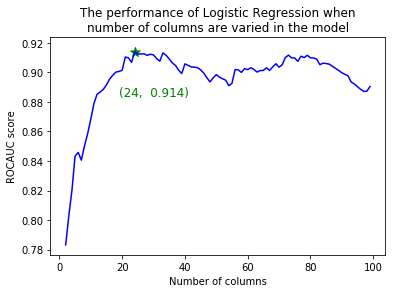

In [8]:
s = '({0:2d}, {1:6.3f})'.format(cols_seq[tuned_score.index(max(tuned_score))], max(tuned_score))

plt.plot(cols_seq, tuned_score, 'b')
plt.title('The performance of Logistic Regression when\nnumber of columns are varied in the model')
plt.xlabel('Number of columns')
plt.ylabel('ROCAUC score')
plt.scatter(cols_seq[tuned_score.index(max(tuned_score))], max(tuned_score), marker='*', s = 100, c = 'g')
plt.text(
    cols_seq[tuned_score.index(max(tuned_score))] - 5
    , max(tuned_score) - 0.03
    , s
    , fontsize=12
    , color = 'green'
)
plt.show()

In [9]:
best_columns = list(
    columns_impact['column_name'][:24]
    )
train_data = train_data[best_columns + ['target']]

train_X, val_X, train_y, val_y = train_test_split(
    train_data[train_data.columns[train_data.columns != 'target']]
    , train_data['target']
    , random_state = 1
    , test_size = 0.2
)

cl_log = LogisticRegression()
cl_log.fit(train_X, train_y)

yhat = cl_log.predict_proba(val_X)[:, 1]

# calculate aucroc
aucroc = roc_auc_score(val_y, yhat)

print('aucroc=%.3f' % aucroc)

aucroc=0.939


In [10]:
cl_log_final = LogisticRegression()
X_train_all = train_data[best_columns]
y_train_all = train_data['target']
X_test = test_data[best_columns]
cl_log_final.fit(X_train_all, y_train_all)
test_yhat = cl_log_final.predict_proba(X_test)[:, 1]
submission_df = pd.DataFrame({'target' : test_yhat}, index = test_data.index)

In [11]:
submission_df.to_csv(f'{data_path}logreg_basic.csv', sep = ',')

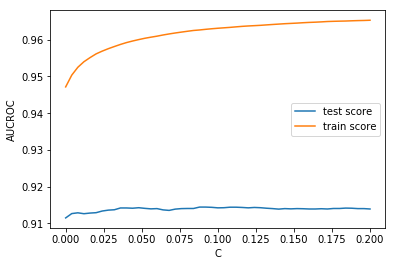

In [12]:
C = np.linspace(start = 0.00001, stop = .2, num=51)
hyperparameters = dict(C = C)
cl_log = LogisticRegression(penalty = 'l2', max_iter = 100)
grid_logl2 = GridSearchCV(cl_log
                        , hyperparameters
                        , cv = my_folds
                        , verbose = 0
                        , scoring = 'roc_auc'
                        , return_train_score = True)
grid_logl2.fit(X_train_all, y)

test_scores = grid_logl2.cv_results_['mean_test_score']
train_scores = grid_logl2.cv_results_['mean_train_score']
param_C = grid_logl2.cv_results_['param_C']
plt.plot(param_C, test_scores, label = 'test score')
plt.plot(param_C, train_scores, label = 'train score')
plt.xlabel('C')
plt.ylabel('AUCROC')
plt.legend()
plt.show()

In [13]:
print('The best value of C:  ' +
      "{:.5f}".format(grid_logl2.best_params_['C']) +
      '\nThe best AUCROC score:  ' +
      "{:.3f}".format(grid_logl2.best_score_)
     )

The best value of C:  0.08801
The best AUCROC score:  0.914


In [14]:
cl_log_final = LogisticRegression(
    penalty = 'l2'
    , max_iter = 100
    , C = 0.08801
)
cl_log_final.fit(X_train_all, y)
test_yhat = cl_log_final.predict_proba(X_test)[:, 1]
submission_df = pd.DataFrame({'target' : test_yhat}, index = test_data.index)
submission_df.to_csv(f'{data_path}logreg_tunedl2.csv', sep = ',')

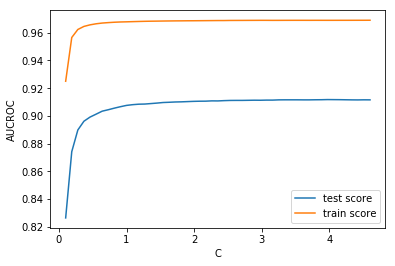

In [15]:
C = np.linspace(start = 0.1, stop = 4.6, num=51)
hyperparameters = dict(C = C)
cl_log = LogisticRegression(penalty = 'l1', max_iter = 100)
grid_logl1 = GridSearchCV(cl_log
                        , hyperparameters
                        , cv = my_folds
                        , verbose = 0
                        , scoring = 'roc_auc'
                        , return_train_score = True)
grid_logl1.fit(X_train_all, y)

test_scores = grid_logl1.cv_results_['mean_test_score']
train_scores = grid_logl1.cv_results_['mean_train_score']
param_C = grid_logl1.cv_results_['param_C']
plt.plot(param_C, test_scores, label = 'test score')
plt.plot(param_C, train_scores, label = 'train score')
plt.xlabel('C')
plt.ylabel('AUCROC')
plt.legend()
plt.show()

In [16]:
print('The best value of C:  ' +
      "{:.5f}".format(grid_logl1.best_params_['C']) +
      '\nThe best AUCROC score:  ' +
      "{:.3f}".format(grid_logl1.best_score_)
     )

The best value of C:  3.97000
The best AUCROC score:  0.912


In [17]:
cl_log_final = LogisticRegression(
    penalty = 'l1'
    , max_iter = 100
    , C = 3.97
)
cl_log_final.fit(X_train_all, y)
test_yhat = cl_log_final.predict_proba(X_test)[:, 1]
submission_df = pd.DataFrame({'target' : test_yhat}, index = test_data.index)
submission_df.to_csv(f'{data_path}logreg_tunedl1.csv', sep = ',')